In [106]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GroupShuffleSplit, cross_validate, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

Here we import the data and add a `correctness` variable that is equal to `1` if ground truth and the answer option are equal.

In [107]:
df = pd.read_csv('../../data/answerList_data.csv')
df['correctness'] = (((df['GroundTruth'] == 0.0) & (df['Answer.option'] == 'NO')) | ((df['GroundTruth'] == 1.0) & (df['Answer.option'] == 'YES'))).astype(int)

df

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.ID,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness
0,261,HIT01_8,0,90.984,4,2,0,0,1,0,...,832cg-7G1i-462:73eI-8E-2g-985,5,Undergraduate_Student,7.0,21,Male,High School,United States,Java; C++; C#,1
1,262,HIT01_8,0,133.711,5,1,0,0,1,0,...,98ce7A-4i-507,4,Undergraduate_Student,10.0,25,Female,High School;University;Web,United States,c#,1
2,263,HIT01_8,0,77.696,5,2,0,0,1,0,...,881AC0I2E-625:135cI3E-7e8-86,5,Professional_Developer,7.0,24,Male,High School;University;Web,United States,C++;Java;PHP,1
3,264,HIT01_8,0,46.644,1,1,0,0,1,0,...,270eG-5c6A3-46:65eI-2i-2I-9-36,5,Professional_Developer,20.0,38,Male,High School;University;Other On the job,USA,C#,1
4,265,HIT01_8,0,215.416,5,5,0,0,1,0,...,844Cg1g5e1-17:255ei-8G8E85-8,3,Undergraduate_Student,5.0,19,Male,High School;University;Web,United States,C++; Java,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2316,HIT08_54,128,220.420,2,4,0,0,1,0,...,1171ea-4g-6C-73-8,3,Graduate_Student,2.0,28,Male,University,USA,C#,1
2576,2317,HIT08_54,128,322.790,4,3,0,0,0,0,...,66AC-5a0g-47-9:1443IA-7C-6e967,5,Professional_Developer,17.0,39,Male,University;Web,USA,C#; VB.NET; Java,0
2577,2318,HIT08_54,128,159.530,5,1,0,0,1,0,...,106iG8G-9I-9-80:590CG-6G-7i-71-9,4,Professional_Developer,10.0,31,Male,High School;University;Web;Other work,usa,C++,1
2578,2319,HIT08_54,128,68.578,5,1,0,0,1,0,...,1221iC8A5A242:495CC9e6a691:11aE2c-4c-9-86,4,Undergraduate_Student,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++,1


Next we add a column that quantifies the complexity of an explanation. We chose the TTR (typen-token ratio) metric. This calculates a ratio of unique tokens in relation to all. We decided against using the Halstead volume since it is more used for the analysis of software projects. In the end we decided to choose the TTR since it is relatively easy to compute in comparison to other NLP-based metrics, where machine learning is used. Furthermore, TTR is commonly used for estimating lexical diversity which implies greater complexity.

In [108]:
df_0 = df[df['GroundTruth'] == 0]
df_1 = df[df['GroundTruth'] == 1]

if len(df_0) > len(df_1):
    df_0_balanced = df_0.sample(len(df_1))
    df_balanced = pd.concat([df_0_balanced, df_1])
else:
    df_1_balanced = df_1.sample(len(df_0))
    df_balanced = pd.concat([df_0, df_1_balanced])

df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

df = df_balanced


In [109]:
def calculate_ttr(text):
    tokens = text.split()
    unique_tokens = set(tokens)
    ttr = len(unique_tokens) / len(tokens) if tokens else 0
    return ttr

df['TTR'] = df['Answer.explanation'].astype(str).apply(calculate_ttr)
df

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness,TTR
0,2287,HIT08_54,124,223.354,3,3,0,0,0,0,...,3,Hobbyist,2.0,31,Male,University,USA,C++,0,1.000000
1,86,HIT02_24,14,290.941,3,3,1,0,0,1,...,5,Hobbyist,4.0,35,Male,University;Web;Other MOOC,USA,Java Python,0,0.829268
2,2350,HIT06_51,92,181.345,3,5,1,0,0,1,...,5,Professional_Developer,3.0,25,Male,University,India,c#,0,0.923077
3,1321,HIT04_7,42,86.696,3,3,0,0,1,0,...,5,Other,20.0,35,Male,High School;University,US,c++,1,0.840000
4,2448,HIT05_35,78,982.453,4,4,0,0,0,0,...,4,Professional_Developer,14.0,36,Female,University,USA,c++,0,0.755556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,HIT02_24,15,134.977,4,2,0,0,0,0,...,3,Hobbyist,32.0,32,Male,University,USA,java,0,0.826087
996,501,HIT03_6,20,408.108,5,2,1,0,0,1,...,3,Professional_Developer,25.0,42,Male,High School;University;Web,United States of America,C#; C++,0,0.809524
997,1410,HIT07_33,97,468.788,3,3,1,1,0,0,...,5,Hobbyist,13.0,29,Male,High School;University;Web,United States,JavaScript,1,1.000000
998,2024,HIT08_54,118,45.236,1,4,0,0,0,0,...,3,Hobbyist,0.0,50,Female,Web,US,none,0,1.000000


In [110]:
df['Answer.option.int'] = df['Answer.option'].map({'NO': 0, 'IDK': 0.5, 'YES': 1})
df['Worker.gender.int'] = df['Worker.gender'].map({'Male': -1, 'Other': 0, 'Female': 1})
df['Worker.profession.int'] = df['Worker.profession'].map({'Other': 0, 'Hobbyist': 1, 'Undergraduate_Student': 2, 'Graduate_Student': 3, 'Professional_Developer':4})


In [111]:
df_holdout = df[df['FailingMethod'].isin(['HIT01_8', 'HIT02_24'])]
df_train = df[~df['FailingMethod'].isin(['HIT01_8', 'HIT02_24'])]

df_train

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness,TTR,Answer.option.int,Worker.gender.int,Worker.profession.int
0,2287,HIT08_54,124,223.354,3,3,0,0,0,0,...,31,Male,University,USA,C++,0,1.000000,1.0,-1,1
2,2350,HIT06_51,92,181.345,3,5,1,0,0,1,...,25,Male,University,India,c#,0,0.923077,0.0,-1,4
3,1321,HIT04_7,42,86.696,3,3,0,0,1,0,...,35,Male,High School;University,US,c++,1,0.840000,0.0,-1,0
4,2448,HIT05_35,78,982.453,4,4,0,0,0,0,...,36,Female,University,USA,c++,0,0.755556,1.0,1,4
5,2275,HIT06_51,95,2295.445,2,5,1,0,0,1,...,18,Female,High School,United States,3,0,0.631579,0.0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,538,HIT03_6,31,1063.672,4,4,0,0,1,0,...,24,Female,Web,usa,vb .net java,1,0.578947,0.0,1,3
996,501,HIT03_6,20,408.108,5,2,1,0,0,1,...,42,Male,High School;University;Web,United States of America,C#; C++,0,0.809524,0.0,-1,4
997,1410,HIT07_33,97,468.788,3,3,1,1,0,0,...,29,Male,High School;University;Web,United States,JavaScript,1,1.000000,1.0,-1,1
998,2024,HIT08_54,118,45.236,1,4,0,0,0,0,...,50,Female,Web,US,none,0,1.000000,1.0,1,1


## First Tree: Decision Tree Classifier

The first approach we were trying out was a decision tree classifier. Since decision trees only accept numerical inputs we had to transform some of the input columns to numerical values. After that we created the train dataset which is used for all further approaches. We also split our data using cross-validation here.

In [112]:
input_cols_full = ['Answer.duration', 'Answer.confidence', 'Answer.difficulty', 'Answer.option.int', 'Answer.order', 'Worker.score', 'Worker.profession', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender.int', 'TTR']
input_cols = ['Answer.duration', 'Answer.confidence', 'Answer.difficulty', 'Answer.option.int', 'Answer.order', 'Worker.score', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender.int', 'TTR']
output_col = 'correctness'

X = df_train[input_cols]
y = df_train[output_col]

groups = df_train['FailingMethod'].values
gss = GroupShuffleSplit(n_splits=len(pd.unique(groups)), test_size=1/len(pd.unique(groups)))

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

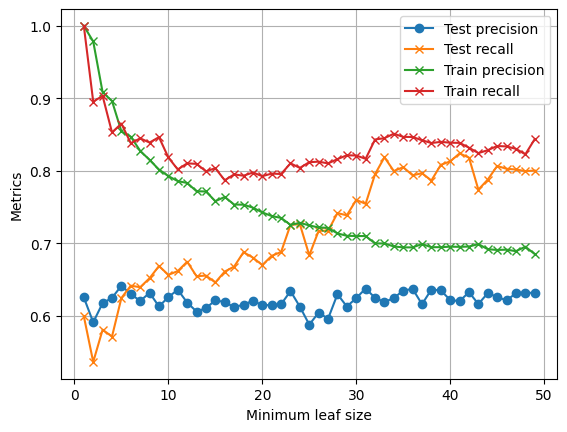

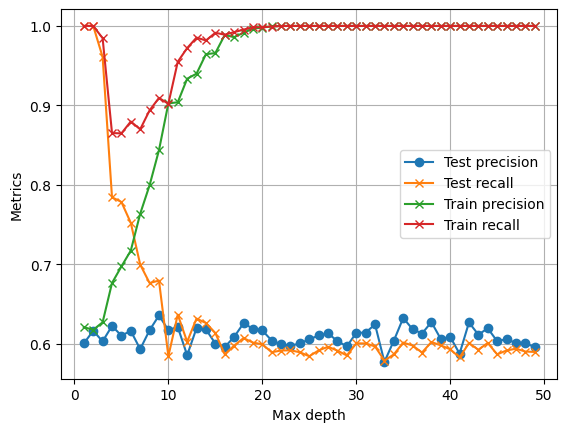

In [113]:
def get_decision_tree_classifier(min_samples_leaf, max_depth, return_model=True, print_metrics=True):
    clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, max_depth=max_depth)

    cv_results = cross_validate(
        clf, X, y, cv=gss, groups=groups,
        scoring=['precision', 'recall'],
        return_estimator=True,
        return_train_score=True
    )
    if print_metrics:
        print("Mean Precision train:", np.mean(cv_results['train_precision']))
        print("Mean Recall train:", np.mean(cv_results['train_recall']))

        print("Precision for each fold:", cv_results['test_precision'])
        print("Mean Precision:", np.mean(cv_results['test_precision']))

        print("Recall for each fold:", cv_results['test_recall'])
        print("Mean Recall:", np.mean(cv_results['test_recall']))

    best_model_idx = np.argmax(cv_results['test_precision'])
    best_model = cv_results['estimator'][best_model_idx]

    if not return_model:
         return np.mean(cv_results['test_precision']), np.mean(cv_results['test_recall']), np.mean(cv_results['train_precision']), np.mean(cv_results['train_recall'])

    return np.mean(cv_results['test_precision']), np.mean(cv_results['test_recall']), np.mean(cv_results['train_precision']), np.mean(cv_results['train_recall']), best_model



max_val = 50
def avg_decision_tree_classifier(leaf_size, depth, runs=10):
    results = [get_decision_tree_classifier(leaf_size, depth, return_model=False, print_metrics=False) for _ in range(runs)]
    avg_result = tuple(sum(values) / runs for values in zip(*results))
    return avg_result

vals_leaf_size = [avg_decision_tree_classifier(leaf_size, 100) for leaf_size in tqdm(range(1, max_val), leave=True)]
vals_depth = [avg_decision_tree_classifier(1, depth) for depth in tqdm(range(1, max_val))]

def plot_diag(vals, x_label):
    y1_vals, y2_vals, y3_vals, y4_vals = zip(*vals)

    plt.plot(range(1, max_val), y1_vals, label='Test precision', marker='o')
    plt.plot(range(1, max_val), y2_vals, label='Test recall', marker='x')
    plt.plot(range(1, max_val), y3_vals, label='Train precision', marker='x')
    plt.plot(range(1, max_val), y4_vals, label='Train recall', marker='x')
    plt.xlabel(x_label)
    plt.ylabel('Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_diag(vals_leaf_size, 'Minimum leaf size')
plot_diag(vals_depth, 'Max depth')

We then trained the model and checked for different minimum leaf sizes and maximum depths to get a better understanding, how the model behaves under changes of these parameters. Although we did not check for combinations of these we clearly got an estimate how they influence the models' performance.

Mean Precision train: 0.6624503772642426
Mean Recall train: 0.9156386488244587
Precision for each fold: [0.57142857 0.56716418 0.57142857 0.57142857 0.57142857 0.57142857]
Mean Precision: 0.5707178393745558
Recall for each fold: [0.88    0.59375 0.88    0.88    0.88    0.88   ]
Mean Recall: 0.8322916666666665


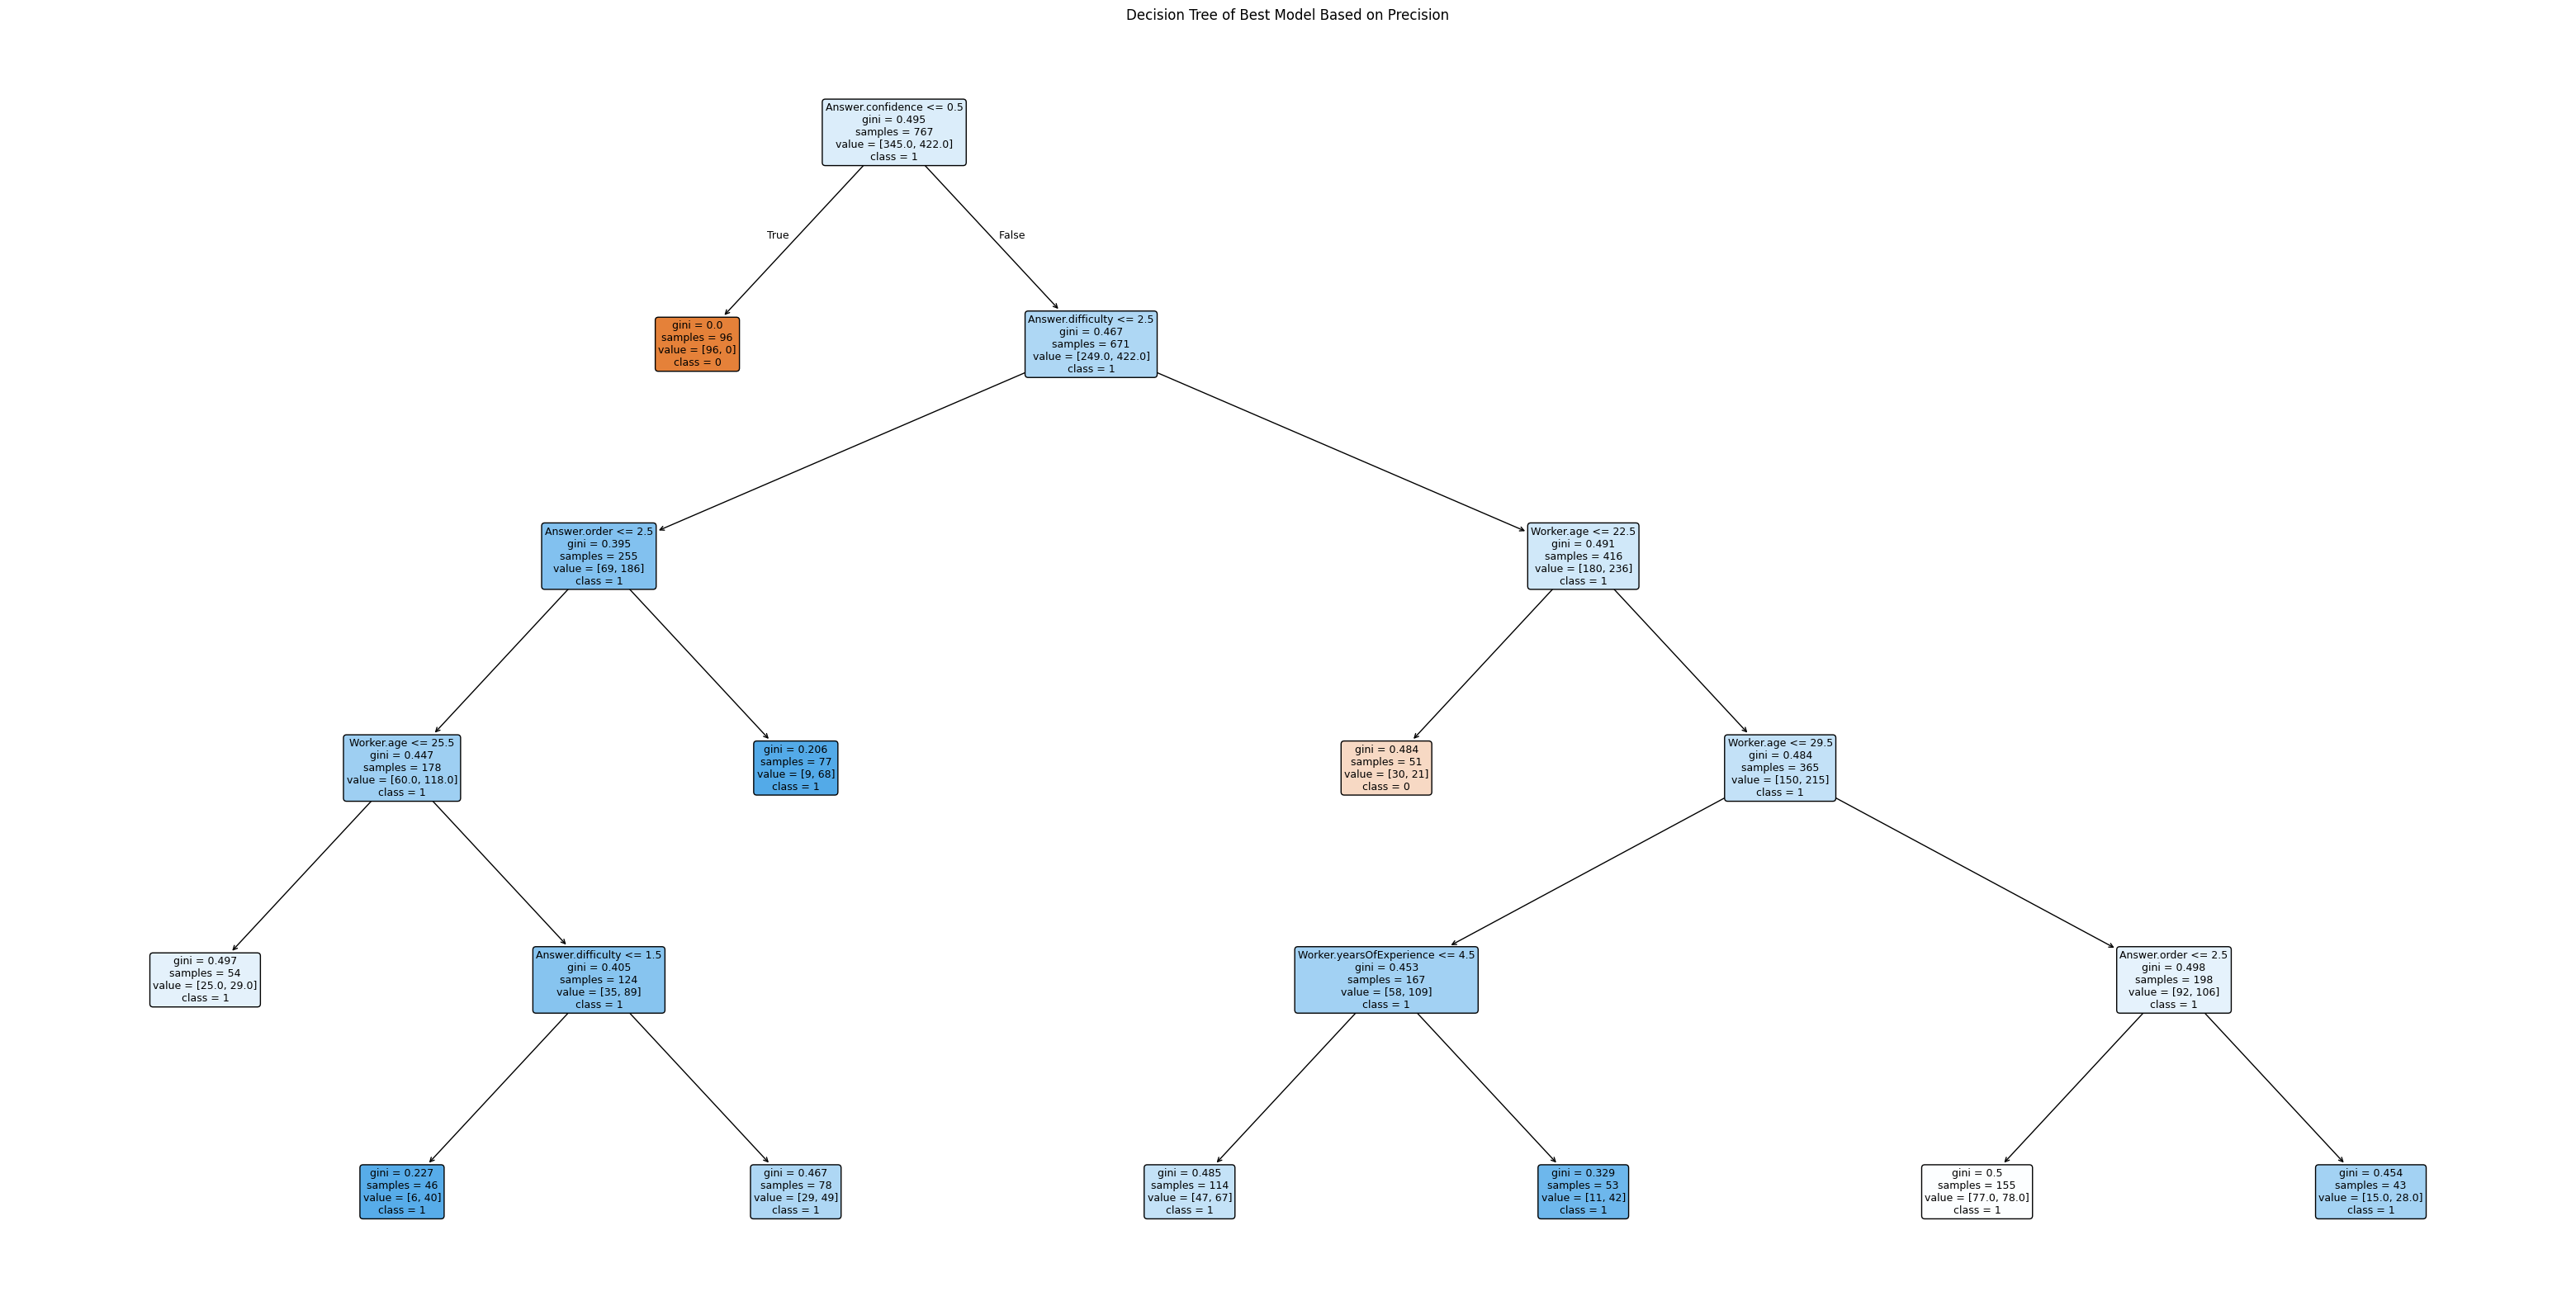

In [115]:
best_model_decision_tree_classifier = get_decision_tree_classifier(40, 5)[4]

plt.figure(figsize=(40, 20))
plot_tree(best_model_decision_tree_classifier, filled=True, feature_names=input_cols, class_names=np.unique(y).astype(str), rounded=True, fontsize=9)
plt.title("Decision Tree of Best Model Based on Precision")
plt.show()

The precision and recall already look pretty good. Something which we noted in the first run is the fact that classes are almost entirely split with the first node in the tree. This is due to a class imbalance. We almost have double as much values where `GroundTruth` is `1`. For this reason we balanced the initial dataset. This way we are not relying on the distribution of the initial dataset. We then trained the model, which can be seen above.

To interpret this tree, we looked at the nodes most close to the root node. With this we can identify the most relevant input columns. In this case it is the users confidence, the perceived difficulty, and the age.

We are also concerned about how easily we can incorporate user demographics into our model. This raises ethical issues, as it could lead to unintended biases or discrimination.

In [116]:
df_train.groupby('GroundTruth').size()

GroundTruth
0    448
1    420
dtype: int64

## Second Tree: Gradient Boosting Classifier

No significant change in precision from average 0.57 to 0.62.

No significant change in recall from average 0.83 to 0.75.

In [120]:
from sklearn.ensemble import GradientBoostingClassifier


input_cols_full = ['Answer.duration', 'Answer.confidence', 'Answer.difficulty', 'Answer.option.int', 'Answer.order', 'Worker.score', 'Worker.profession', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender.int', 'TTR']
input_cols = ['Answer.duration', 'Answer.confidence', 'Answer.difficulty', 'Answer.option.int', 'Answer.order', 'Worker.score', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender.int', 'TTR']
output_col = 'correctness'

X_gb = df_train[input_cols]
y_gb = df_train[output_col]

groups = df_train['FailingMethod'].values
gss = GroupShuffleSplit(n_splits=len(pd.unique(groups)), test_size=1/len(pd.unique(groups)))

clf = GradientBoostingClassifier(min_samples_leaf=40, max_depth=5)


cv_results = cross_validate(
        clf, X_gb, y_gb, cv=gss, groups=groups,
        scoring=['precision', 'recall'],
        return_estimator=True,
        return_train_score=True
    )

print("Mean Precision train:", np.mean(cv_results['train_precision']))
print("Mean Recall train:", np.mean(cv_results['train_recall']))

print("Precision for each fold:", cv_results['test_precision'])
print("Mean Precision:", np.mean(cv_results['test_precision']))

print("Recall for each fold:", cv_results['test_recall'])
print("Mean Recall:", np.mean(cv_results['test_recall']))

best_model_gb_idx = np.argmax(cv_results['test_precision'])
best_model_gb = cv_results['estimator'][best_model_gb_idx]


Mean Precision train: 0.8416649759010246
Mean Recall train: 0.9434395712164455
Precision for each fold: [0.696      0.56382979 0.59649123 0.56382979 0.70676692 0.56382979]
Mean Precision: 0.6151245845109227
Recall for each fold: [0.64925373 0.7260274  0.80952381 0.7260274  0.86238532 0.7260274 ]
Mean Recall: 0.7498741756248055


## Third Tree: Minimal number of input columns for decision tree

By reducing number of inputs change in precision from 0.57 to 0.66.

By reducing number of inputs no significant change in recall from 0.83 to 0.81.

Mean Precision train: 0.6562981906047117
Mean Recall train: 0.864321068380728
Precision for each fold: [0.69127517 0.57758621 0.69918699 0.69127517 0.58208955 0.69918699]
Mean Precision: 0.6567666797409443
Recall for each fold: [0.94495413 0.91780822 0.64179104 0.94495413 0.78       0.64179104]
Mean Recall: 0.811883094268509


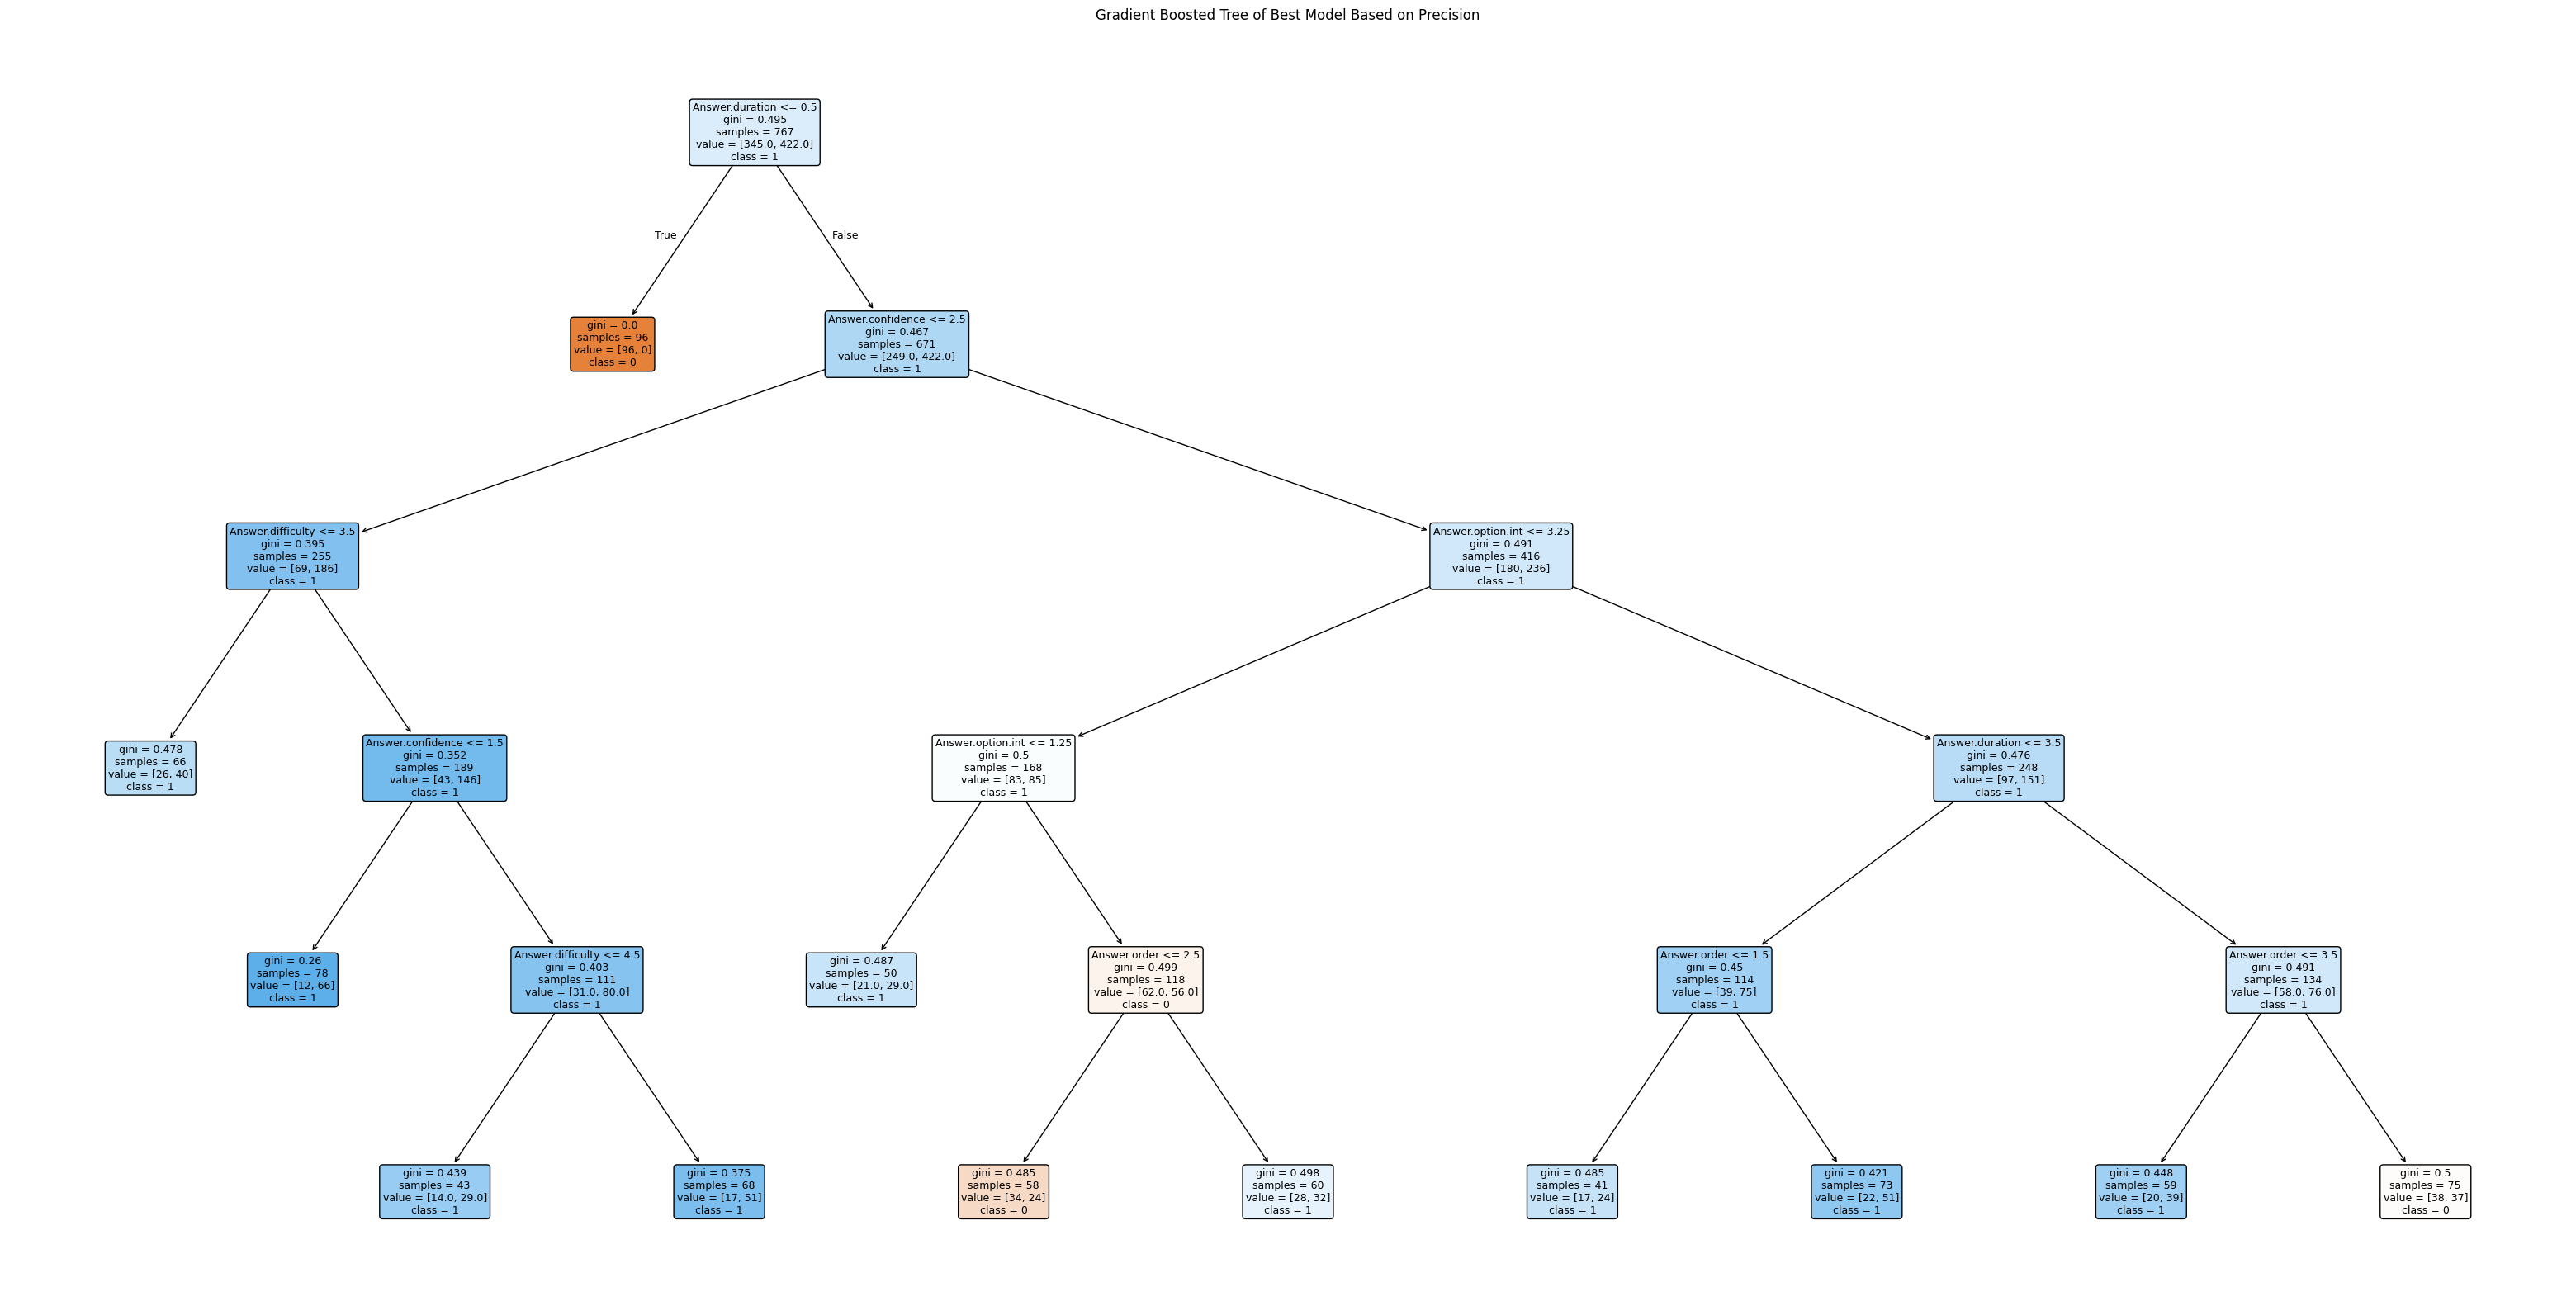

In [122]:
input_cols_full = ['Answer.duration', 'Answer.confidence', 'Answer.difficulty', 'Answer.option.int', 'Answer.order', 'Worker.score', 'Worker.profession.int', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender.int', 'TTR']
input_cols_minimal = ['Answer.confidence', 'Answer.difficulty', 'Worker.score', 'Worker.yearsOfExperience', 'Worker.profession.int']
output_col = 'correctness'

X_gb = df_train[input_cols_minimal]
y_gb = df_train[output_col]

groups = df_train['FailingMethod'].values
gss = GroupShuffleSplit(n_splits=len(pd.unique(groups)), test_size=1/len(pd.unique(groups)))

clf = DecisionTreeClassifier(min_samples_leaf=40, max_depth=10)

cv_results = cross_validate(
        clf, X_gb, y_gb, cv=gss, groups=groups,
        scoring=['precision', 'recall'],
        return_estimator=True,
        return_train_score=True
    )

print("Mean Precision train:", np.mean(cv_results['train_precision']))
print("Mean Recall train:", np.mean(cv_results['train_recall']))

print("Precision for each fold:", cv_results['test_precision'])
print("Mean Precision:", np.mean(cv_results['test_precision']))

print("Recall for each fold:", cv_results['test_recall'])
print("Mean Recall:", np.mean(cv_results['test_recall']))

best_model_gb_min_idx = np.argmax(cv_results['test_precision'])
best_model_gb_min = cv_results['estimator'][best_model_gb_idx]

plt.figure(figsize=(40, 20))
plot_tree(best_model_gb_min, filled=True, feature_names=input_cols, class_names=np.unique(y).astype(str), rounded=True, fontsize=9)
plt.title("Gradient Boosted Tree of Best Model Based on Precision")
plt.show()


In [34]:
df_train

,Answer.duration,Answer.confidence,Answer.difficulty,Answer.option.int,Answer.order,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.gender.int,TTR
320,225.484,4,2,0.0,2,5,Other,20.0,35,-1,0.875000
321,75.758,5,2,0.0,2,4,Graduate_Student,5.0,26,-1,0.708333
322,396.716,5,2,1.0,2,4,Professional_Developer,10.0,33,-1,0.576923
323,899.377,4,3,0.0,2,5,Hobbyist,5.0,33,-1,1.000000
324,253.272,0,5,0.5,2,3,Undergraduate_Student,3.0,49,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
2575,220.420,2,4,0.0,1,3,Graduate_Student,2.0,28,-1,0.766667
2576,322.790,4,3,1.0,1,5,Professional_Developer,17.0,39,-1,0.928571
2577,159.530,5,1,0.0,1,4,Professional_Developer,10.0,31,-1,1.000000
2578,68.578,5,1,0.0,1,4,Undergraduate_Student,4.0,19,-1,1.000000


## Holdout set predicition

Here we use the last model to label each row from the holdout set.

In [124]:
groups = df_holdout.groupby('FailingMethod')

precision_per_group = {}
recall_per_group = {}

for method, group in groups:
    X_group = group[input_cols_minimal]
    y_group = group[output_col]

    y_pred = best_model_gb_min.predict(X_group)

    precision = precision_score(y_group, y_pred)
    recall = recall_score(y_group, y_pred)

    precision_per_group[method] = precision
    recall_per_group[method] = recall

for method in precision_per_group:
    print(f"FailingMethod: {method}")
    print(f"Precision: {precision_per_group[method]}")
    print(f"Recall: {recall_per_group[method]}")
    print("-" * 30)


FailingMethod: HIT01_8
Precision: 0.7894736842105263
Recall: 0.8181818181818182
------------------------------
FailingMethod: HIT02_24
Precision: 0.45
Recall: 0.6206896551724138
------------------------------


/var/folders/f7/k6ksdyss1rdd4kq9f0lc_kl00000gn/T/ipykernel_58821/1012204187.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bug_rows['Explanation_Size'] = bug_rows['Answer.explanation'].apply(len)


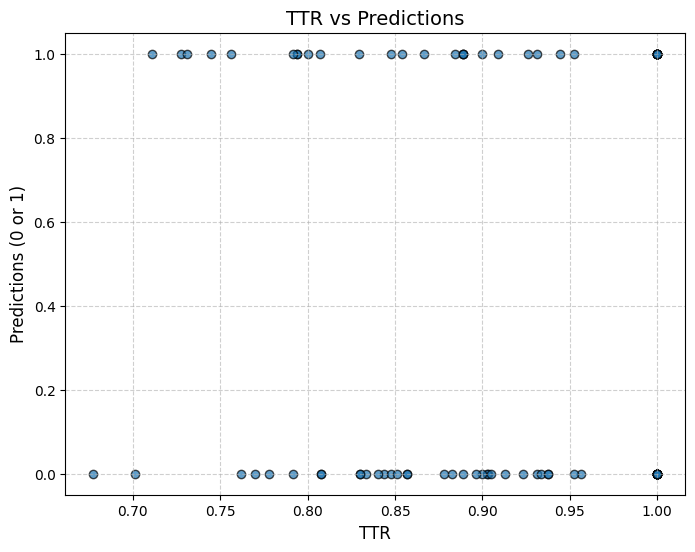

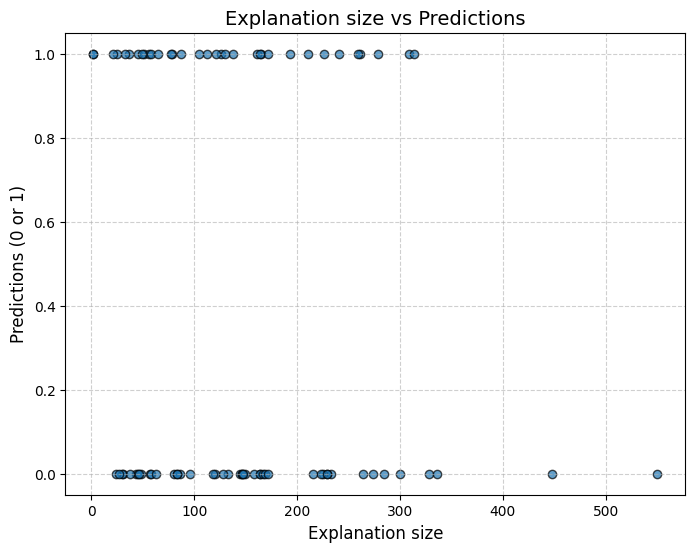

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

bug_rows = df_holdout[df_holdout['GroundTruth'] == 1]

bug_rows['Explanation_Size'] = bug_rows['Answer.explanation'].apply(len)

y_pred = best_model_decision_tree_classifier.predict(bug_rows[input_cols])


plt.figure(figsize=(8, 6))
plt.scatter(bug_rows['TTR'], y_pred, alpha=0.7, edgecolor='k')
plt.title('TTR vs Predictions', fontsize=14)
plt.xlabel('TTR', fontsize=12)
plt.ylabel('Predictions (0 or 1)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(bug_rows['Explanation_Size'], y_pred, alpha=0.7, edgecolor='k')
plt.title('Explanation size vs Predictions', fontsize=14)
plt.xlabel('Explanation size', fontsize=12)
plt.ylabel('Predictions (0 or 1)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In the diagrams above we look at rows that host a bug. We then display the distribution of our predicted values by explanation complexity (TTR) and explanation size.

In [52]:
df_holdout[df_holdout['TP'] == 1 ]


,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness,TTR,Answer.option.int,Worker.gender.int
20,441,HIT01_8,1,140.407,4,3,1,1,0,0,...,3.0,49,Female,University,US,php,1,1.000000,1.0,1
22,443,HIT01_8,1,112.409,5,2,1,1,0,0,...,5.0,20,Male,University;Web,USA,c#,1,0.931034,1.0,-1
23,444,HIT01_8,1,76.418,5,1,1,1,0,0,...,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++,1,0.903226,1.0,-1
24,445,HIT01_8,1,261.928,5,2,1,1,0,0,...,1.0,25,Female,University,USA,java,1,0.770000,1.0,1
25,446,HIT01_8,1,236.045,5,1,1,1,0,0,...,5.0,29,Male,University;Other On the job,USA,Python; SQL; Java,1,0.882353,1.0,-1
27,448,HIT01_8,1,259.790,3,3,1,1,0,0,...,1.0,30,Female,University,united states,none,1,0.902439,1.0,1
28,449,HIT01_8,1,230.142,4,3,1,1,0,0,...,4.0,35,Male,High School,USA,php and C++,1,0.830189,1.0,-1
29,450,HIT01_8,1,253.302,4,2,1,1,0,0,...,4.0,35,Male,University;Web;Other MOOC,USA,Java Python,1,0.761905,1.0,-1
30,451,HIT01_8,1,89.521,4,3,1,1,0,0,...,14.0,34,Male,High School;University;Web;Other books,Russia,C++;Object Pascal,1,0.937500,1.0,-1
34,455,HIT01_8,1,161.419,4,4,1,1,0,0,...,2.0,24,Male,University,India,c; c++,1,0.807692,1.0,-1


## Specification II

In [38]:
from openai import OpenAI

question_groups = df_holdout[df_holdout['TP'] == 1 ].groupby(['FailingMethod', 'Question.ID'])
client = OpenAI(
    api_key=""
)

explanations_list = []

for m, group in question_groups:
    explanations = group['Answer.explanation'].to_list()
    explanations_list.append(explanations)
    print('Number of explanations', len(group['Answer.explanation']))


print('Number of groups', len(question_groups))


Number of explanations 12
Number of explanations 15
Number of explanations 4
Number of explanations 9
Number of explanations 9
Number of groups 5


We created two prompts to compare the results of the different consolidations. The first prompt contains an introduction and then the specification as given on the slides. The second bug is a rewrite of the task while specifying that the result should be as short as possible.

In [39]:
def get_prompt_1(explanations):
        return f"""
I give you the following task, after that the relevant data. You have to solve the task with the data (filtered explanations) I give you, each separate explanation is separated by a newline character

for the correct answers to the inspection tasks hosting the bug, prompt the LLM
to generate a single explanation by merging the participants’ explanations in a way that minimizes
redundant information, while keeping the information that would be necessary for someone else to fix the
bug.
• Types of information that, if present in the explanation, should be preserved - how the program works,
how the failure is happening, what is problem in the code, etc.

{explanations}

"""

def get_prompt_2(explanations):
        return f"""
Please summarize these reports of the same bug. Remove redundant information, but make sure that every information given in the explanations is retained that would be needed to fix the bug. Summarize the report of the bug concisely. Keep the summary as short as possible.

These the reports:

{explanations}

"""

In [55]:
for explanations in explanations_list:
    print(get_prompt_2(str(explanations)))


Please summarize these reports of the same bug. Remove redundant information, but make sure that every information given in the explanations is retained that would be needed to fix the bug. Summarize the report of the bug concisely. Keep the summary as short as possible.

These the reports:

['Minutes are set to -15; which is less then 0 and it throws illegal arg exception', 'In the code there is a check that 0 <= minutes < 60 and the minutesOffset is -15 which does not fall into these prarmeters thus throwing an Exception', 'There is a logical check for if minuteOffset is less than 0 or greater than 59 causing it to throw an exception because the value is out of bounds (negative number)', 'YES. The issue is on line 279 (as I explained in my first question; of which I misunderstood that I was only being asked about the specific issue; not generalized issue). On line 279 the variable "minutesOffSet" is parameterized to throw an exception if it is < 0 or > 59. Line 279 should read "if (

In [40]:
def get_results(get_prompt_function):

    results = []

    for explanations in tqdm(explanations_list):

        chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": get_prompt_function(str(explanations)),
            }
        ],
        model="gpt-4o-mini",
    )

        results.append(chat_completion.choices[0].message.content)

    results_df = pd.DataFrame(results, columns=['text']).reset_index()

    results_df['complexity'] = results_df['text'].astype(str).apply(calculate_ttr)
    results_df['length'] = results_df['text'].astype(str).apply(len)

    return results_df

In [41]:
from IPython.core.display import Markdown

prompt_1_results = get_results(get_prompt_1)
prompt_2_results = get_results(get_prompt_2)

display(prompt_1_results)
display(prompt_2_results)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

,index,text,complexity,length
0,0,"The issue arises from the way the variable ""mi...",0.679487,978
1,1,The bug arises from the way the program handle...,0.593301,1287
2,2,The issue with the program seems to revolve ar...,0.684685,671
3,3,The bug arises from improper value handling fo...,0.644578,1008
4,4,The issue arises from the calculation of varia...,0.625000,931


,index,text,complexity,length
0,0,"The bug arises from line 279 of the code, wher...",0.741935,609
1,1,**Bug Summary:**\nThe method throws an `Illega...,0.750000,592
2,2,"There is an issue related to the variable ""min...",0.753247,430
3,3,**Bug Summary:**\n\nThe color parameter 'g' is...,0.735849,669
4,4,"The bug report indicates that the variable ""g""...",0.679612,650


Here we can find the generated results. As you can see the first prompt generated results with a higher length and less complexity. Alone these two metrics show what we commonly see when using LLMs, they repeat themselves.
When actually reading through the outputs you can also see that with the first prompt, we have more repetition of information then with the second one. The results of the second also feel way more concise and better to read.

In [42]:
display(Markdown('# Prompt 1'))

for index, result in enumerate(prompt_1_results['text']):
    display(Markdown(f'## Result for Text {index + 1}'))
    display(Markdown(result))

display(Markdown('# Prompt 2'))

for index, result in enumerate(prompt_2_results['text']):
    display(Markdown(f'## Result for Text {index + 1}'))
    display(Markdown(result))

# Prompt 1

## Result for Text 1

The issue arises from the way the variable "minutesOffset" is validated in the code. The current check on line 279 incorrectly asserts that the value must be within the range of 0 to 59, throwing an IllegalArgumentException when the value is set to -15, as it fails this condition. The proper validation should allow for negative values within the range of -59 to +59, reflecting the requirement that some implementations expect minutesOffset to accept negative values. Therefore, line 279 should be modified to read: `if (minutesOffset < -59 || minutesOffset > 59) {`. This change would prevent the method from throwing an exception for valid negative inputs and thus, allow the process to proceed correctly without prematurely terminating. The error message generated, "Minutes out of range: + minutesOffset," indicates that the input does not meet the expected criteria but does not take into account the broader range that should be permitted, as noted in the documentation.

## Result for Text 2

The bug arises from the way the program handles negative minute offsets in the method. The value of `minutesOffset` is expected to be between -59 and +59, according to the comments in the code. However, the conditional statement on line 279 only checks if `minutesOffset` is less than 0, which fails to account for valid negative minute values when the hour input is negative.

When the argument -15 is passed, the conditional `minutesOffset < 0` on line 279 evaluates to true, causing the program to throw an `IllegalArgumentException` on line 280. The issue stems from the assumption that all negative minutes are invalid, neglecting the condition where negative minutes are permissible if the hour input is also negative. The comment block above the method inaccurately suggests that only values below -59 or above 59 are problematic, but does not adequately clarify the acceptable range when both hours and minutes are negative.

To fix this bug, the code should be modified to check for a range of -59 to +59 for minute offsets, but also take into consideration the hour input when evaluating negative minute values. The misinterpretation caused by a line break in the comment may lead developers to overlook the important distinction regarding combining negative hours and minutes.

## Result for Text 3

The issue with the program seems to revolve around the handling of the offset parameters, particularly within the code around lines 279 and 284. Specifically, the variable "minutesOffSet" is currently set to throw an exception if its value is less than 0. This should be corrected to less than -59 to prevent erroneous behavior. Additionally, it has been noted that the "offset" variable is still zero, which can lead to it being out of the acceptable range. The parameters being passed may also contribute to the final output being "millis out of range." All of these factors suggest that the incorrect handling of offset variables is causing the program to malfunction.

## Result for Text 4

The bug arises from improper value handling for the color parameters being passed to the Color constructor. In this case, the "g" variable is being assigned a value of -0.5, which is outside the valid range of 0 to 255 for a Color object. Although the values should ideally be between 0.0 and 1.0 for float parameters in the Color constructor, the logic in the code fails to properly check and sanitize this range. Specifically, the variable "value" is incorrectly used in line 117 instead of "v," leading to potential negative outputs after calculations. There is no validation to ensure that the lower bound of "value" is positive; thus, a negative value can lead to an invalid state. The check against lowerBound and upperBound does occur, but the result stored in "v" is never utilized in the program, resulting in the error when passing -0.5. Additionally, an IllegalArgumentException should ideally be thrown when invalid arguments are provided, but this is not happening in the current implementation.

## Result for Text 5

The issue arises from the calculation of variable "g," which is likely leading to a negative integer value when a negative parameter is passed. This negative value for "g" is causing the exception in the Color class constructor, indicating that the color parameter is outside the acceptable range. Specifically, since "g" is defined with an integer type, it's possible that an inappropriate value is being assigned to it, particularly if the calculation does not include checks to prevent negative outcomes. Additionally, the definitions of `this.lowerBound` and `this.upperBound` should be examined to further understand the acceptable range for color parameters. Any adjustments to the calculation of "g" should ensure it results in a valid float number within the bounds defined for the Color class. The error suggests the need for proper validation to avoid passing an illegal or inappropriate g value to the Color constructor.

# Prompt 2

## Result for Text 1

The bug arises from line 279 of the code, where the variable `minutesOffset` is incorrectly validated. Currently, it checks if `minutesOffset < 0` or `minutesOffset > 59`, which causes an `IllegalArgumentException` when `minutesOffset` is set to -15 (as in the input from `DateTimeZone.forOffsetHoursMinutes(-2, -15)`). The validation should be adjusted to allow for negative values in the range of -59 to 59, changing the condition to `if (minutesOffset < -59 || minutesOffset > 59) {`. This change will align the code with the documented behavior that allows `minutesOffset` to be negative in certain cases.

## Result for Text 2

**Bug Summary:**
The method throws an `IllegalArgumentException` when the `minutesOffset` is less than 0, such as -15, due to the conditional check on line 279 (`minutesOffset < 0`). The code currently only checks if `minutesOffset` is between -59 and 59 when it should allow negative minutes if the hours are also negative. The proper check should account for both hour and minute values together, as the comments indicate that negative minutes are acceptable with negative hours but not with positive hours. The existing conditional fails to recognize this, leading to erroneous exceptions.

## Result for Text 3

There is an issue related to the variable "minutesOffSet" on line 279, which currently throws an exception if it is less than 0. This should be changed to < -59. Additionally, the offset variable remains zero, which may lead to it being out of range, and there could be issues with parameters passed that may cause an "answer millis out of range" error. Line 284 may also involve an error related to the offset described in hours.

## Result for Text 4

**Bug Summary:**

The color parameter 'g' is being passed a value of -0.5, which is outside the valid range of 0-255 for the Color object. Additionally, the value is not being properly validated against the lower and upper bounds, allowing negative values. The variable "value" is used incorrectly on line 117 instead of "v", and "v" is not utilized in the code, leading to unintended values outside the expected range. This situation may trigger an IllegalArgumentException when invalid arguments are provided to the Color constructor, which requires values between 0.0 and 1.0. Proper bounds checking and correction of variable usage is necessary to fix these issues.

## Result for Text 5

The bug report indicates that the variable "g" is causing an exception in the Color constructor, likely due to a negative value being passed. The calculations for "g" may not adequately constrain its value, especially when a negative parameter is involved. Additionally, "g" should be a float, and its value may fall outside the acceptable range for the Color class. Issues with the definitions of `this.lowerBound` and `this.upperBound` need to be examined to fully understand the problem. It is suggested that "g" should be computed using "v" instead of "value." An IllegalArgumentException is thrown when an illegal argument is passed to a method.

In [44]:
import nltk
from rouge import Rouge

def calculate_bleu(hyp, ref):
    hypothesis = hyp.split()
    reference = ref.split()
    return nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)

rouge = Rouge()
def calculate_rouge(hyp, ref):
    scores = rouge.get_scores(hyp, ref)
    return scores[0]['rouge-1']['f']

In [46]:
def display_bleu_rouge(prompt_results):

    explanation_indices = []
    hyp_texts = []
    ref_texts = []
    bleu_vals = []
    rouge_vals = []

    for index, explanations in enumerate(explanations_list):
        hyp = prompt_results.iloc[index]['text']


        for ref in explanations:
            if len(ref.split(' ')) < 5:
                continue
            explanation_indices.append(index)
            hyp_texts.append(hyp)
            ref_texts.append(ref)
            bleu_vals.append(calculate_bleu(hyp, ref))
            rouge_vals.append(calculate_rouge(hyp, ref))

    data = {
        'Explanation index': explanation_indices,
        'Hyp text': hyp_texts,
        'Ref text': ref_texts,
        'bleu': bleu_vals,
        'rouge': rouge_vals,
    }


    similarity_metrics = pd.DataFrame(data)
    display(similarity_metrics)
    return similarity_metrics

sim_1 = display_bleu_rouge(prompt_1_results)
sim_2 = display_bleu_rouge(prompt_2_results)

/Users/lucas/PycharmProjects/ASE-GenAI/venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/lucas/PycharmProjects/ASE-GenAI/venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/lucas/PycharmProjects/ASE-GenAI/venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower o

,Explanation index,Hyp text,Ref text,bleu,rouge
0,0,"The issue arises from the way the variable ""mi...",Minutes are set to -15; which is less then 0 a...,1.945730e-155,0.115702
1,0,"The issue arises from the way the variable ""mi...",In the code there is a check that 0 <= minutes...,2.799551e-155,0.212121
2,0,"The issue arises from the way the variable ""mi...",There is a logical check for if minuteOffset i...,7.466081e-79,0.180451
3,0,"The issue arises from the way the variable ""mi...",YES. The issue is on line 279 (as I explained ...,7.492230e-02,0.340659
4,0,"The issue arises from the way the variable ""mi...","The variable ""minutesOffset"" is checked incorr...",7.536857e-79,0.266667
5,0,"The issue arises from the way the variable ""mi...",This variable contains a value of -15 as set b...,2.529680e-155,0.265734
6,0,"The issue arises from the way the variable ""mi...",Yes; the variable gets set to -15 through the ...,1.214415e-78,0.283784
7,0,"The issue arises from the way the variable ""mi...",As noted in the comments; valid input for minu...,5.316009e-02,0.352941
8,0,"The issue arises from the way the variable ""mi...","the variable should be defined as ""unsigned in...",2.463918e-155,0.133333
9,0,"The issue arises from the way the variable ""mi...",The value of minutes offset does not have vali...,2.354133e-155,0.190476


/Users/lucas/PycharmProjects/ASE-GenAI/venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/lucas/PycharmProjects/ASE-GenAI/venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/lucas/PycharmProjects/ASE-GenAI/venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower o

,Explanation index,Hyp text,Ref text,bleu,rouge
0,0,"The bug arises from line 279 of the code, wher...",Minutes are set to -15; which is less then 0 a...,2.319247e-155,0.116279
1,0,"The bug arises from line 279 of the code, wher...",In the code there is a check that 0 <= minutes...,2.824572e-155,0.185567
2,0,"The bug arises from line 279 of the code, wher...",There is a logical check for if minuteOffset i...,1.043248e-231,0.183673
3,0,"The bug arises from line 279 of the code, wher...",YES. The issue is on line 279 (as I explained ...,9.587271e-02,0.367347
4,0,"The bug arises from line 279 of the code, wher...","The variable ""minutesOffset"" is checked incorr...",9.622510e-79,0.280000
5,0,"The bug arises from line 279 of the code, wher...",This variable contains a value of -15 as set b...,1.173323e-231,0.277778
6,0,"The bug arises from line 279 of the code, wher...",Yes; the variable gets set to -15 through the ...,1.374787e-78,0.353982
7,0,"The bug arises from line 279 of the code, wher...",As noted in the comments; valid input for minu...,5.131808e-02,0.288136
8,0,"The bug arises from line 279 of the code, wher...","the variable should be defined as ""unsigned in...",3.432870e-155,0.164706
9,0,"The bug arises from line 279 of the code, wher...",The value of minutes offset does not have vali...,8.772636e-232,0.087912


Here we computed the BLEU and ROUGE scores for each pairing of LLM generated explanation and original explanation. We directly notice that the BLEU score always is way smaller than the ROUGE score. Since we have a text summarization task here and BLEU is designed to be used for scoring machine translations and ROUGE for scoring text summarization, this makes perfect sense.

To better compare these values, we calculate the mean and median for each generated explanation for the results of prompt 1 and 2.

In [53]:
def group_similarities_mean(similarity_metrics):
    display(similarity_metrics[['Explanation index', 'Hyp text', 'bleu', 'rouge']].groupby('Hyp text').mean())

def group_similarities_median(similarity_metrics):
    display(similarity_metrics[['Explanation index', 'Hyp text', 'bleu', 'rouge']].groupby('Hyp text').mean())

display(Markdown('## Mean'))
group_similarities_mean(sim_1)
group_similarities_mean(sim_2)

display(Markdown('## Median'))
group_similarities_median(sim_1)
group_similarities_median(sim_2)

## Mean

,Explanation index,bleu,rouge
Hyp text,,,
"The bug arises from improper value handling for the color parameters being passed to the Color constructor. In this case, the ""g"" variable is being assigned a value of -0.5, which is outside the valid range of 0 to 255 for a Color object. Although the values should ideally be between 0.0 and 1.0 for float parameters in the Color constructor, the logic in the code fails to properly check and sanitize this range. Specifically, the variable ""value"" is incorrectly used in line 117 instead of ""v,"" leading to potential negative outputs after calculations. There is no validation to ensure that the lower bound of ""value"" is positive; thus, a negative value can lead to an invalid state. The check against lowerBound and upperBound does occur, but the result stored in ""v"" is never utilized in the program, resulting in the error when passing -0.5. Additionally, an IllegalArgumentException should ideally be thrown when invalid arguments are provided, but this is not happening in the current implementation.",3.0,0.013240,0.209991
"The bug arises from the way the program handles negative minute offsets in the method. The value of `minutesOffset` is expected to be between -59 and +59, according to the comments in the code. However, the conditional statement on line 279 only checks if `minutesOffset` is less than 0, which fails to account for valid negative minute values when the hour input is negative.\n\nWhen the argument -15 is passed, the conditional `minutesOffset < 0` on line 279 evaluates to true, causing the program to throw an `IllegalArgumentException` on line 280. The issue stems from the assumption that all negative minutes are invalid, neglecting the condition where negative minutes are permissible if the hour input is also negative. The comment block above the method inaccurately suggests that only values below -59 or above 59 are problematic, but does not adequately clarify the acceptable range when both hours and minutes are negative.\n\nTo fix this bug, the code should be modified to check for a range of -59 to +59 for minute offsets, but also take into consideration the hour input when evaluating negative minute values. The misinterpretation caused by a line break in the comment may lead developers to overlook the important distinction regarding combining negative hours and minutes.",1.0,0.009592,0.154260
"The issue arises from the calculation of variable ""g,"" which is likely leading to a negative integer value when a negative parameter is passed. This negative value for ""g"" is causing the exception in the Color class constructor, indicating that the color parameter is outside the acceptable range. Specifically, since ""g"" is defined with an integer type, it's possible that an inappropriate value is being assigned to it, particularly if the calculation does not include checks to prevent negative outcomes. Additionally, the definitions of `this.lowerBound` and `this.upperBound` should be examined to further understand the acceptable range for color parameters. Any adjustments to the calculation of ""g"" should ensure it results in a valid float number within the bounds defined for the Color class. The error suggests the need for proper validation to avoid passing an illegal or inappropriate g value to the Color constructor.",4.0,0.006492,0.187085
"The issue arises from the way the variable ""minutesOffset"" is validated in the code. The current check on line 279 incorrectly asserts that the value must be within the range of 0 to 59, throwing an IllegalArgumentException when the value is set to -15, as it fails this condition. The proper validation should allow for negative values within the range of -59 to +59, reflecting the requirement that some implementations expect minutesOffset to accept negative values. Therefore, line 279 should be modified to read: `if (minutesOffset < -59 || minutesOffset > 59) {`. This change would prevent the method from throwing an exceptio

,Explanation index,bleu,rouge
Hyp text,,,
"**Bug Summary:**\n\nThe color parameter 'g' is being passed a value of -0.5, which is outside the valid range of 0-255 for the Color object. Additionally, the value is not being properly validated against the lower and upper bounds, allowing negative values. The variable ""value"" is used incorrectly on line 117 instead of ""v"", and ""v"" is not utilized in the code, leading to unintended values outside the expected range. This situation may trigger an IllegalArgumentException when invalid arguments are provided to the Color constructor, which requires values between 0.0 and 1.0. Proper bounds checking and correction of variable usage is necessary to fix these issues.",3.0,0.015981,0.211727
"**Bug Summary:**\nThe method throws an `IllegalArgumentException` when the `minutesOffset` is less than 0, such as -15, due to the conditional check on line 279 (`minutesOffset < 0`). The code currently only checks if `minutesOffset` is between -59 and 59 when it should allow negative minutes if the hours are also negative. The proper check should account for both hour and minute values together, as the comments indicate that negative minutes are acceptable with negative hours but not with positive hours. The existing conditional fails to recognize this, leading to erroneous exceptions.",1.0,0.002713,0.177409
"The bug arises from line 279 of the code, where the variable `minutesOffset` is incorrectly validated. Currently, it checks if `minutesOffset < 0` or `minutesOffset > 59`, which causes an `IllegalArgumentException` when `minutesOffset` is set to -15 (as in the input from `DateTimeZone.forOffsetHoursMinutes(-2, -15)`). The validation should be adjusted to allow for negative values in the range of -59 to 59, changing the condition to `if (minutesOffset < -59 || minutesOffset > 59) {`. This change will align the code with the documented behavior that allows `minutesOffset` to be negative in certain cases.",0.0,0.019828,0.244316
"The bug report indicates that the variable ""g"" is causing an exception in the Color constructor, likely due to a negative value being passed. The calculations for ""g"" may not adequately constrain its value, especially when a negative parameter is involved. Additionally, ""g"" should be a float, and its value may fall outside the acceptable range for the Color class. Issues with the definitions of `this.lowerBound` and `this.upperBound` need to be examined to fully understand the problem. It is suggested that ""g"" should be computed using ""v"" instead of ""value."" An IllegalArgumentException is thrown when an illegal argument is passed to a method.",4.0,0.002562,0.188345
"There is an issue related to the variable ""minutesOffSet"" on line 279, which currently throws an exception if it is less than 0. This should be changed to < -59. Additionally, the offset variable remains zero, which may lead to it being out of range, and there could be issues with parameters passed that may cause an ""answer millis out of range"" error. Line 284 may also involve an error related to the offset described in hours.",2.0,0.031342,0.288888


## Median

,Explanation index,bleu,rouge
Hyp text,,,
"The bug arises from improper value handling for the color parameters being passed to the Color constructor. In this case, the ""g"" variable is being assigned a value of -0.5, which is outside the valid range of 0 to 255 for a Color object. Although the values should ideally be between 0.0 and 1.0 for float parameters in the Color constructor, the logic in the code fails to properly check and sanitize this range. Specifically, the variable ""value"" is incorrectly used in line 117 instead of ""v,"" leading to potential negative outputs after calculations. There is no validation to ensure that the lower bound of ""value"" is positive; thus, a negative value can lead to an invalid state. The check against lowerBound and upperBound does occur, but the result stored in ""v"" is never utilized in the program, resulting in the error when passing -0.5. Additionally, an IllegalArgumentException should ideally be thrown when invalid arguments are provided, but this is not happening in the current implementation.",3.0,0.013240,0.209991
"The bug arises from the way the program handles negative minute offsets in the method. The value of `minutesOffset` is expected to be between -59 and +59, according to the comments in the code. However, the conditional statement on line 279 only checks if `minutesOffset` is less than 0, which fails to account for valid negative minute values when the hour input is negative.\n\nWhen the argument -15 is passed, the conditional `minutesOffset < 0` on line 279 evaluates to true, causing the program to throw an `IllegalArgumentException` on line 280. The issue stems from the assumption that all negative minutes are invalid, neglecting the condition where negative minutes are permissible if the hour input is also negative. The comment block above the method inaccurately suggests that only values below -59 or above 59 are problematic, but does not adequately clarify the acceptable range when both hours and minutes are negative.\n\nTo fix this bug, the code should be modified to check for a range of -59 to +59 for minute offsets, but also take into consideration the hour input when evaluating negative minute values. The misinterpretation caused by a line break in the comment may lead developers to overlook the important distinction regarding combining negative hours and minutes.",1.0,0.009592,0.154260
"The issue arises from the calculation of variable ""g,"" which is likely leading to a negative integer value when a negative parameter is passed. This negative value for ""g"" is causing the exception in the Color class constructor, indicating that the color parameter is outside the acceptable range. Specifically, since ""g"" is defined with an integer type, it's possible that an inappropriate value is being assigned to it, particularly if the calculation does not include checks to prevent negative outcomes. Additionally, the definitions of `this.lowerBound` and `this.upperBound` should be examined to further understand the acceptable range for color parameters. Any adjustments to the calculation of ""g"" should ensure it results in a valid float number within the bounds defined for the Color class. The error suggests the need for proper validation to avoid passing an illegal or inappropriate g value to the Color constructor.",4.0,0.006492,0.187085
"The issue arises from the way the variable ""minutesOffset"" is validated in the code. The current check on line 279 incorrectly asserts that the value must be within the range of 0 to 59, throwing an IllegalArgumentException when the value is set to -15, as it fails this condition. The proper validation should allow for negative values within the range of -59 to +59, reflecting the requirement that some implementations expect minutesOffset to accept negative values. Therefore, line 279 should be modified to read: `if (minutesOffset < -59 || minutesOffset > 59) {`. This change would prevent the method from throwing an exceptio

,Explanation index,bleu,rouge
Hyp text,,,
"**Bug Summary:**\n\nThe color parameter 'g' is being passed a value of -0.5, which is outside the valid range of 0-255 for the Color object. Additionally, the value is not being properly validated against the lower and upper bounds, allowing negative values. The variable ""value"" is used incorrectly on line 117 instead of ""v"", and ""v"" is not utilized in the code, leading to unintended values outside the expected range. This situation may trigger an IllegalArgumentException when invalid arguments are provided to the Color constructor, which requires values between 0.0 and 1.0. Proper bounds checking and correction of variable usage is necessary to fix these issues.",3.0,0.015981,0.211727
"**Bug Summary:**\nThe method throws an `IllegalArgumentException` when the `minutesOffset` is less than 0, such as -15, due to the conditional check on line 279 (`minutesOffset < 0`). The code currently only checks if `minutesOffset` is between -59 and 59 when it should allow negative minutes if the hours are also negative. The proper check should account for both hour and minute values together, as the comments indicate that negative minutes are acceptable with negative hours but not with positive hours. The existing conditional fails to recognize this, leading to erroneous exceptions.",1.0,0.002713,0.177409
"The bug arises from line 279 of the code, where the variable `minutesOffset` is incorrectly validated. Currently, it checks if `minutesOffset < 0` or `minutesOffset > 59`, which causes an `IllegalArgumentException` when `minutesOffset` is set to -15 (as in the input from `DateTimeZone.forOffsetHoursMinutes(-2, -15)`). The validation should be adjusted to allow for negative values in the range of -59 to 59, changing the condition to `if (minutesOffset < -59 || minutesOffset > 59) {`. This change will align the code with the documented behavior that allows `minutesOffset` to be negative in certain cases.",0.0,0.019828,0.244316
"The bug report indicates that the variable ""g"" is causing an exception in the Color constructor, likely due to a negative value being passed. The calculations for ""g"" may not adequately constrain its value, especially when a negative parameter is involved. Additionally, ""g"" should be a float, and its value may fall outside the acceptable range for the Color class. Issues with the definitions of `this.lowerBound` and `this.upperBound` need to be examined to fully understand the problem. It is suggested that ""g"" should be computed using ""v"" instead of ""value."" An IllegalArgumentException is thrown when an illegal argument is passed to a method.",4.0,0.002562,0.188345
"There is an issue related to the variable ""minutesOffSet"" on line 279, which currently throws an exception if it is less than 0. This should be changed to < -59. Additionally, the offset variable remains zero, which may lead to it being out of range, and there could be issues with parameters passed that may cause an ""answer millis out of range"" error. Line 284 may also involve an error related to the offset described in hours.",2.0,0.031342,0.288888


Here we can clearly see that the average and median BLEU and ROUGE values in 3/4 cases are larger for the explanations of prompt 2. This means that the results of the second prompt have a higher similarity with the human generated explanations than the first prompt. This observation further demonstrates that the second prompt performs better than the first one.


# Reflection

### Concerns About Guaranteeing the Quality of the Data:
- Data quality depends on participants' skills and effort.
- Explanations vary in detail and correctness, complicating classifier integration but aiding answer evaluation.
- Aggregating multiple answers (e.g., voting) reduces reliance on individual responses.
- Participants' honesty in answering the questionnaire cannot be guaranteed.

---

### Concerns About Keeping the Classifier Up-to-Date:
- Classifier insights may not generalize to different contexts (e.g., project size or domain-specific requirements).
- Demographic variations among programmers may impact classifier accuracy.
- For new domains or programmers, retraining on fresh data is essential before making predictions.

---

### Concerns About Testing the Output of the Classifier and LLM:
- Classifier output correctness can be tested effectively.
- Understanding classifier decision rules (e.g., tree nodes) is possible but challenging.
- LLM outputs are harder to quantify; BLEU and ROUGE metrics have limitations:
  - Do not account for synonyms.
  - Lack consistency due to LLM's non-deterministic responses.
- Human evaluation remains crucial for qualitative assessment.

---

### Concerns About Estimating the Quality of Consolidated Explanations:
- Automated evaluation of consolidated explanations is highly complex or impractical.
- Human evaluators require domain knowledge to assess explanation quality.

---

### Concerns About Debugging the Integration Between Classifier and LLM:
- Classifier errors degrade LLM output quality due to incorrect input explanations.
- Automated validation of classifier results is not feasible (necessitating the classifier's existence).
- Debugging requires simultaneous consideration of both classifier and LLM components.

---